In [1]:
## Print multiple output per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
## Importing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [3]:
## Pandas Display options
pd.set_option('display.max_columns',0)
pd.set_option('display.max_colwidth',0)

# Read data

In [4]:
## Reading relevant data
match_lvl_data = pd.read_csv('data/match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('data/batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('data/bowler_level_scorecard.csv')
train_data = pd.read_csv('data/train_data_with_samplefeatures.csv')
test_data = pd.read_csv('data/test_data_with_samplefeatures.csv')

# Printing shape and sample rows of each dataset

In [5]:
match_lvl_data.shape
match_lvl_data.head(2)

(1689, 30)

,match id,team1,team2,winner,by,win amount,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,umpire1,umpire2,inning1_runs,inning1_wickets,inning1_balls,inning2_runs,inning2_wickets,inning2_balls,team1_id,team1_roster_ids,team2_id,team2_roster_ids,series_type,winner_id,player_of_the_match_id
0,8638034,Nn Ds,Wn,Wn,wickets,9.0,Wn,field,By Ol,Mount Maunganui,2021-01-01,night match,Sr Sh,2020/21,17681,Dn Mw,TJ Pe,148,6,130,152.0,1.0,97.0,17982,7907451.0:4381761.0:31464.0:258649.0:4949790.0:3834305.0:3776849.0:6718340.0:3566240.0:4950364.0:7543647.0,18570,2653993.0:6718326.0:6718382.0:2486896.0:2288789.0:4950224.0:8187878.0:3083667.0:4950294.0:6718396.0:1585464.0,other_domestic,18570,NaN
1,8588005,Me Rs,Sy Tr,Sy Tr,runs,7.0,Sy Tr,field,Ca Ol,Carrara,2021-01-01,night match,Bg Bh Le,2020/21,6663,D Tr,PJ Ge,166,6,106,117.0,2.0,74.0,33942,37351.0:46794.0:5406540.0:2231928.0:181404.0:1594319.0:7534687.0:7537067.0:1905847.0:8339701.0:7620346.0,33963,1506098.0:1749075.0:36665.0:2083409.0:7534652.0:5788320.0:1612610.0:5509524.0:5497274.0:3876613.0:8193310.0,other_domestic,33963,1749075.0


In [6]:
batsman_lvl_data.shape
batsman_lvl_data.head(2)

(24483, 21)

,match id,batsman,batsman_id,batsman_details,is_batsman_captain,is_batsman_keeper,inning,runs,balls_faced,over_faced_first,wicket kind,out_by_bowler,out_by_fielder,bowler_id,bowler_details,is_bowler_keeper,is_bowler_captain,strike_rate,Fours,Sixes,match_dt
0,8638034,KD Ce,7907451.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,7,5,1.1,caught,JS Nm,TM Jn,2486896.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,140.0,1.0,NaN,2021-01-01
1,8638034,TL St,4381761.0,NZ:Right-hand bat:None:,0.0,1.0,1,46,46,1.2,caught,R Ra,MG Bl,6718382.0,NZ:Left-hand bat:Slow left-arm orthodox:,0.0,0.0,100.0,4.0,1.0,2021-01-01


In [7]:
bowler_lvl_data.shape
bowler_lvl_data.head(2)

(18539, 18)

,match id,bowler,bowler_id,bowler_details,is_bowler_captain,is_bowler_keeper,inning,runs,wicket_count,balls_bowled,economy,maiden,dots,Fours,Sixes,wides,noballs,match_dt
0,8638034,BV Ss,6718396.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,21,0,12,10.5,0,3.0,1,1,3,1,2021-01-01
1,8638034,HK Bt,1585464.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,1,34,1,24,8.5,0,7.0,3,1,2,0,2021-01-01


In [8]:
train_data.shape
train_data.head(2)

(948, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000


In [9]:
test_data.shape
test_data.head(2)

(271, 21)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:2590251.0:7785497.0:7785553.0:3296264.0:4613622.0:2904796.0:3685289.0,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:1613870.0:8934764.0:2721480.0:1632819.0:2789604.0:6489846.0:1565507.0,Ud Ss of Aa,field,Bo Ac Cb,Bulawayo,2022-07-11,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000000,0.019608,NaN,0.00,NaN
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,night match,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.5


In [10]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

# Code to plot RnP

In [11]:
from matplotlib import pyplot as plt
plt.style.use('seaborn');
import re

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.
    
    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.
    
    Output-
    1. Rank and Plot
    
    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();

/var/folders/y9/_3j91y_j5_sb6xs2vpf3h9840000gn/T/ipykernel_42870/1758012790.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn');


# Helper function

In [12]:
def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.
    
    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}
    
    Output-None
    
    Returns- dataframe having bowling/batting stats from last n games of a player before an input date. 
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'
        
    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)


# Feature creation

1. team_count_runs_last15 <br>
combined feature of no of 100,50,30

In [13]:
def runs_Lastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        df_rel['gte_50runs'] = np.where(df_rel['runs']>=50, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        df_rel['gte_100runs'] = np.where(df_rel['runs']>=100, 1, 0) 
        df_rel['gte_30runs'] = np.where(df_rel['runs']>=30, 1, 0) 

        final = 0.20* np.nansum(df_rel['gte_100runs']) + 0.40*np.nansum(df_rel['gte_50runs']) + 0.40*np.nansum(df_rel['gte_30runs'])
        res_list.append(final)

    return np.nansum(res_list)


In [14]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['team1_count_runs_last15'] = train_data.progress_apply(lambda x: \
            runs_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Computing number of 50 runs in last 15 games for team2 for train dataset.
train_data['team2_count_runs_last15'] = train_data.progress_apply(lambda x: \
            runs_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


100%|██████████| 948/948 [00:14<00:00, 65.94it/s]


In [15]:
# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_count_runs_last15'] = (train_data['team1_count_runs_last15']+1)/(train_data['team2_count_runs_last15']+1)
train_data.drop(columns=['team1_count_runs_last15','team2_count_runs_last15'], inplace=True) # dropping intermediate columns


In [16]:
train_data.shape
train_data.tail(2)

(948, 25)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_runs_last15
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.735537
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,3.034483


slope: 0.63 / 0.37 =  1.69


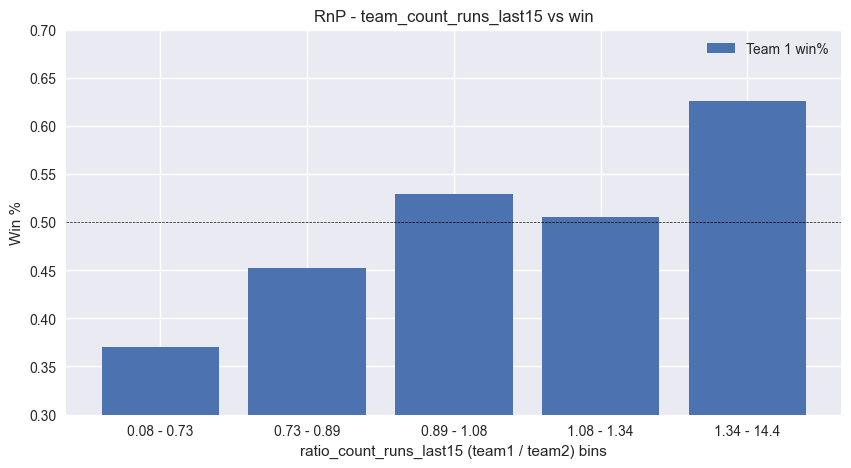

In [17]:
# RnP of team_count_50runs_last15 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'team_count_runs_last15')

In [18]:
## Doing similar process for test dataset

test_data['team1_count_runs_last15'] = test_data.progress_apply(lambda x: \
            runs_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_count_runs_last15'] = test_data.progress_apply(lambda x: \
            runs_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team_count_runs_last15'] = (test_data['team1_count_runs_last15'])/(test_data['team2_count_runs_last15']+1)
test_data.drop(columns=['team1_count_runs_last15','team2_count_runs_last15'], inplace=True)
test_data.shape
test_data.head(2)

100%|██████████| 271/271 [00:04<00:00, 65.58it/s]


(271, 22)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_runs_last15
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:2590251.0:7785497.0:7785553.0:3296264.0:4613622.0:2904796.0:3685289.0,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:1613870.0:8934764.0:2721480.0:1632819.0:2789604.0:6489846.0:1565507.0,Ud Ss of Aa,field,Bo Ac Cb,Bulawayo,2022-07-11,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000000,0.019608,NaN,0.00,NaN,0.000000
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,night match,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.5,0.730337


#### 2. Winning consistency <br>

In [19]:
def consistencyLastn(team_id, date, n):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.
    
    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.
    
    Output- None
    
    Returns- Float value denoting win% of the team in last n games.
    '''
    # filter out games with either team1/2_id as input team id, match_dt being before current game's date, sort desc by date, and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n) 
    
    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # count number of rows having winner as the input team
    # p, last = None, None
    if win_count == 0:
        p = 0
        # last = 0
    else:
        p = round(win_count/df_rel.shape[0], 2)
        # last = 1 if df_rel['winner_id'][0]==team_id else 0
        # last = 1 if df_rel['winner_id'].iloc[0] == team_id else 0
        # last = 0
    
    # last = 1 if df_rel['winner_id'].iloc[0] == team_id else 0
    if not df_rel.empty:
        last = 1 if df_rel['winner_id'].iloc[0] == team_id else 0
    else:
        last = 0
        
    final = 0.30*last + 0.70*p
    # if win_count == 0:
    #     return 0
    # return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points
    return final


In [20]:
# Compute team1's win% in last 5 games
train_data['team1_consistency_last10'] = train_data.progress_apply(lambda x: \
                                  consistencyLastn(x['team1_id'], x['match_dt'], 10), axis=1)
# Compute team2's win% in last 5 games
train_data['team2_consistency_last10'] = train_data.progress_apply(lambda x: \
                                  consistencyLastn(x['team2_id'], x['match_dt'], 10), axis=1)


100%|██████████| 948/948 [00:00<00:00, 2027.89it/s]


In [21]:
# Take the ratio of (team1's win% in their last 5 games)/(team2's win% in their last 5 games). Adding 1 to avoid divide by zero error
train_data['team_consistency_last10'] = (train_data['team1_consistency_last10']+1)/(train_data['team2_consistency_last10']+1)
train_data.drop(columns=['team1_consistency_last10', 'team2_consistency_last10'], inplace=True) # drop intermediate columns


In [22]:
train_data.shape
train_data.head(2)

(948, 26)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_runs_last15,team_consistency_last10
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,1,1.000000,0.744186
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,0,1.063492,0.986111


In [23]:
## Similar process for test data

test_data['team1_consistency_last10'] = test_data.progress_apply(lambda x: \
            consistencyLastn(team_id=x['team1_id'], date=x['match_dt'], n=10), axis=1)
test_data['team2_consistency_last10'] = test_data.progress_apply(lambda x: \
            consistencyLastn(team_id=x['team2_id'], date=x['match_dt'], n=10), axis=1)
test_data['team_consistency_last10'] = (test_data['team1_consistency_last10']+1)/(test_data['team2_consistency_last10']+1)
test_data.drop(columns=['team1_consistency_last10','team2_consistency_last10'], inplace=True)
test_data.shape
test_data.head(2)

100%|██████████| 271/271 [00:00<00:00, 1960.17it/s]


(271, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_runs_last15,team_consistency_last10
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:2590251.0:7785497.0:7785553.0:3296264.0:4613622.0:2904796.0:3685289.0,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:1613870.0:8934764.0:2721480.0:1632819.0:2789604.0:6489846.0:1565507.0,Ud Ss of Aa,field,Bo Ac Cb,Bulawayo,2022-07-11,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000000,0.019608,NaN,0.00,NaN,0.000000,0.740741
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,night match,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.5,0.730337,1.000000


slope: 0.55 / 0.4 =  1.36


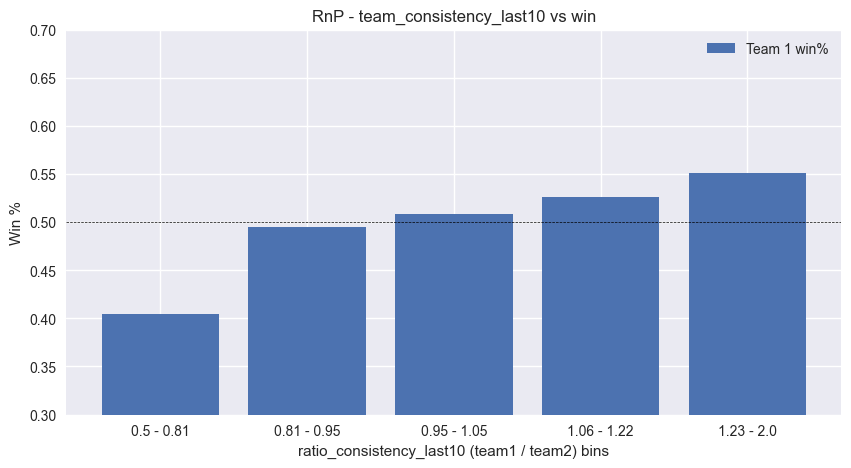

In [24]:
# RnP of team_winp_last5 computed over the train data.
createRnP(train_data, 'team_consistency_last10')#, ylim_ub=0.65)

In [25]:
# train_data.drop(columns=['winner_01'], inplace=True) # Dropping intermediate column made to plot RnP.


3. teamonly_avg_runs_last15 <br>
team1's avg inning runs in last 15 games

In [26]:
# ## derived feature computed using toss winner & toss decision to denote the inning team1 bats.
# # If team1 won the toss and chose to bat or team2 won the toss and chose to bowl, the feature takes the value 1, else 2.
# match_lvl_data['team1_bat_inning'] = np.where( ((match_lvl_data['team1']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='bat'))|\
#                                                ((match_lvl_data['team2']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='field')) , 1, 2)


In [27]:
# match_lvl_data.head(2)


In [28]:
# def teamAvgRunsLastn(team_id, date, n):
#     '''
#     Function to calculate a team's average runs in their last n games.
    
#     Input-
#     1. team_id: ID of the team to calculate average runs.
#     2. date: match date of the current game for which the feature is calculated.
#     3. n: look-back window of games for the team.
    
#     Output- None
    
#     Return- Float value denoting average of runs scored by team1 in their last n games.
#     '''
#     # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
#     df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
#                       ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
#                         .sort_values(by='match_dt', ascending=False).head(n)
#     # combine two dataframes - one where input team is batting first, and another one where input team is batting second.
#     df_rel = pd.concat([ df_rel[df_rel['team1_bat_inning']==1][['inning1_runs']].rename(columns={'inning1_runs':'runs'}), \
#                          df_rel[df_rel['team1_bat_inning']==2][['inning2_runs']].rename(columns={'inning2_runs':'runs'}) ] )
#     return df_rel['runs'].mean() # return mean of the combined dataframe.

In [29]:
# # Compute average runs scored by team1 in their last 15 games for train data.
# train_data['team1only_avg_runs_last15'] = train_data.progress_apply(lambda x: \
#                                   teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)


In [30]:
# # Similarly for test data.
# test_data['team1only_avg_runs_last15'] = test_data.progress_apply(lambda x: \
#             teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)
# test_data.shape
# test_data.head(2)


In [31]:
# train_data.shape
# train_data.head(2)

#### 4. teamone_winp_teamtwo_last5 <br>
  Team1's win percentage againts Team2 in last 5 games

In [32]:
def winpCrossLastn(team1_id, team2_id, date, n):
    '''
    Function to compute team1's win% against team2 from the current game in their past n encounters.
    
    Input-
    1. team1_id: ID of team1 to calculate win% of.
    2. team2_id: ID of team2 to calculate win% against.
    3: date: match date of the current game for which the feature is to be calculated.
    4. n: look-back window of games for both these teams.
    
    Output- None
    
    Returns- Float value denoting team1's win% against team2 in their past n games against each other.
    '''
    # filter out games where either team1_id is input team1 and team2_id is input team2, or where team2_id is input team1 and team1_id is input team2.
    # Also, match date is less than current games's input date, sort desc by date and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      (((match_lvl_data['team1_id']==team1_id)&(match_lvl_data['team2_id']==team2_id))|((match_lvl_data['team1_id']==team2_id)&(match_lvl_data['team2_id']==team1_id)))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    win_count = df_rel[df_rel['winner_id']==team1_id].shape[0] # Counting number of rows (games) where winner is input team1.
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return Float denoting team1's win% against team2 in past n games rounded to 2 decimal places.


In [33]:
# Compute team1 win% against team2 in their past 5 encounters for train data.
train_data['team1_winp_team2_last5'] = train_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 5), axis=1)


100%|██████████| 948/948 [00:00<00:00, 1485.77it/s]


In [34]:
train_data.shape
train_data.head(2)

(948, 27)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_runs_last15,team_consistency_last10,team1_winp_team2_last5
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,1,1.000000,0.744186,100.0
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,0,1.063492,0.986111,50.0


In [35]:
# Similarly for test data.
test_data['team1_winp_team2_last5'] = test_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 5), axis=1)


100%|██████████| 271/271 [00:00<00:00, 1691.87it/s]


In [36]:
test_data.shape
test_data.head(2)

(271, 24)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_runs_last15,team_consistency_last10,team1_winp_team2_last5
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:2590251.0:7785497.0:7785553.0:3296264.0:4613622.0:2904796.0:3685289.0,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:1613870.0:8934764.0:2721480.0:1632819.0:2789604.0:6489846.0:1565507.0,Ud Ss of Aa,field,Bo Ac Cb,Bulawayo,2022-07-11,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000000,0.019608,NaN,0.00,NaN,0.000000,0.740741,0.00
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,night match,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.5,0.730337,1.000000,66.67


slope: 0.52 / 0.45 =  1.16


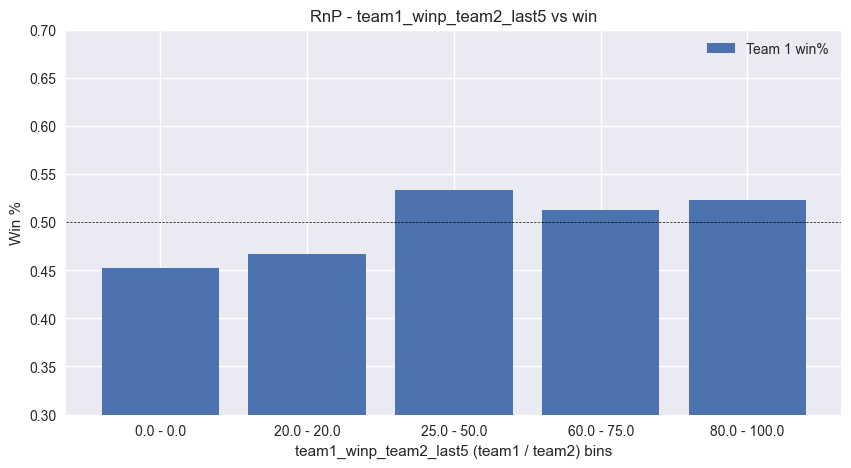

In [37]:
createRnP(train_data, 'team1_winp_team2_last5')

5. ground_avg_runs_last15 <br>
average runs scored in the ground in last 15 games

In [38]:
# def avgRunsGround(ground_id, date, n):
#     '''
#     Function to calculate average runs scored in ground/venue.
    
#     Input-
#     1. ground_id: ID of the ground to calculate the feature for.
#     2. date: match date of the current game to calculate the feature for.
#     3. n: look-back window of games for the ground.
    
#     Output- None
    
#     Returns- Average runs scored in the ground.
#     '''
#     # filter out games with ground_id being the input ground_id and date earlier than current game's input date. Sort desc by date, and select top n rows (games).
#     df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&(match_lvl_data['ground_id']==ground_id)].sort_values(by='match_dt', ascending=False).head(n)
#     df_rel['avg_runs_inn'] = (df_rel['inning1_runs']+df_rel['inning2_runs'])/2 # take the mean of inning1_runs and inning2_runs in a separate column.
#     return df_rel['avg_runs_inn'].mean() # Return the mean value of the computed column above.


In [39]:
# ## Calculate average runs in the ground for last 15 games hosted in that venue for train data.
# train_data['ground_avg_runs_last15'] = train_data.progress_apply(lambda x: \
#                                   avgRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)
# ## Similarly for test data.
# test_data['ground_avg_runs_last15'] = test_data.progress_apply(lambda x: \
#                                   avgRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)


In [40]:
# train_data.shape
# train_data.head(2)

In [41]:
# test_data.shape
# test_data.head(2)

#### 6. Team_batting_avg_last15 <br>

In [42]:
def batavgLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- bat avg of all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    total_runs = 0
    times_dismissed = 0
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.

        total_runs += df_rel['runs'].sum()
        times_dismissed += df_rel['wicket kind'].apply(lambda x: x != '').sum()

        # if times_dismissed == 0:
        #     batting_average = np.nan #float('inf')  # If never dismissed, average is infinite
        # else:
        #     batting_average = total_runs / times_dismissed
        
        # res_list.append(batting_average)

    # return np.nanmean(res_list)
    return total_runs/times_dismissed


In [43]:
train_data['team1_bat_avg_last15'] = train_data.progress_apply(lambda x: \
                                  batavgLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_bat_avg_last15'] = train_data.progress_apply(lambda x: \
                                  batavgLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


  2%|▏         | 18/948 [00:00<00:11, 80.84it/s]/var/folders/y9/_3j91y_j5_sb6xs2vpf3h9840000gn/T/ipykernel_42870/1313283307.py:32: RuntimeWarning: invalid value encountered in scalar divide
  return total_runs/times_dismissed
  6%|▌         | 54/948 [00:00<00:10, 81.78it/s]/var/folders/y9/_3j91y_j5_sb6xs2vpf3h9840000gn/T/ipykernel_42870/1313283307.py:32: RuntimeWarning: invalid value encountered in scalar divide
  return total_runs/times_dismissed
  9%|▊         | 81/948 [00:00<00:10, 82.16it/s]/var/folders/y9/_3j91y_j5_sb6xs2vpf3h9840000gn/T/ipykernel_42870/1313283307.py:32: RuntimeWarning: invalid value encountered in scalar divide
  return total_runs/times_dismissed
 19%|█▉        | 180/948 [00:02<00:09, 81.88it/s]/var/folders/y9/_3j91y_j5_sb6xs2vpf3h9840000gn/T/ipykernel_42870/1313283307.py:32: RuntimeWarning: invalid value encountered in scalar divide
  return total_runs/times_dismissed
 22%|██▏       | 207/948 [00:02<00:09, 81.88it/s]/var/folders/y9/_3j91y_j5_sb6xs2vpf3h9840000gn

#### 7. Team_batting_strike_rate_last15 <br>

In [44]:
def batstrLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- bat avg of all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    # res_list = []
    total_runs = 0
    total_balls_played = 0
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.

        # strike_rate_avg = df_rel['strike_rate'].mean()
        total_runs += df_rel['runs'].sum()
        total_balls_played += df_rel['balls_faced'].sum()

        # strike_rate_avg = (total_runs/total_balls_played) * 100.0
        
        # res_list.append(strike_rate_avg)

    # return np.nanmean(res_list)
    return (total_runs/total_balls_played) * 100.0


In [45]:
train_data['team1_bat_strike_rate_last15'] = train_data.progress_apply(lambda x: \
                                  batstrLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_bat_strike_rate_last15'] = train_data.progress_apply(lambda x: \
                                  batstrLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


  2%|▏         | 20/948 [00:00<00:10, 88.16it/s]/var/folders/y9/_3j91y_j5_sb6xs2vpf3h9840000gn/T/ipykernel_42870/46329268.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return (total_runs/total_balls_played) * 100.0
  6%|▌         | 56/948 [00:00<00:10, 86.61it/s]/var/folders/y9/_3j91y_j5_sb6xs2vpf3h9840000gn/T/ipykernel_42870/46329268.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return (total_runs/total_balls_played) * 100.0
100%|██████████| 948/948 [00:10<00:00, 86.26it/s]


In [46]:
# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team1_bat_strenght_last15'] = 0.4*train_data['team1_bat_avg_last15'] + 0.6*train_data['team1_bat_strike_rate_last15']
train_data['team2_bat_strenght_last15'] = 0.4*train_data['team2_bat_avg_last15'] + 0.6*train_data['team2_bat_strike_rate_last15']

train_data['team_bat_strenght_last15'] = train_data['team1_bat_strenght_last15']/ train_data['team2_bat_strenght_last15']

# train_data.drop(columns=['team1_bat_avg_last15','team2_bat_avg_last15','team1_bat_strike_rate_last15','team2_bat_strike_rate_last15','team1_bat_strenght_last15','team2_bat_strenght_last15'], inplace=True) # dropping intermediate columns


In [47]:
train_data.shape
train_data.tail(2)

(948, 34)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_runs_last15,team_consistency_last10,team1_winp_team2_last5,team1_bat_avg_last15,team2_bat_avg_last15,team1_bat_strike_rate_last15,team2_bat_strike_rate_last15,team1_bat_strenght_last15,team2_bat_strenght_last15,team_bat_strenght_last15
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.735537,1.363636,66.67,20.865385,20.860294,136.477987,141.850000,90.232946,93.454118,0.965532
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,3.034483,1.537190,100.00,17.335616,12.583333,137.554348,116.452442,89.466855,74.904799,1.194408


slope: 0.65 / 0.4 =  1.61


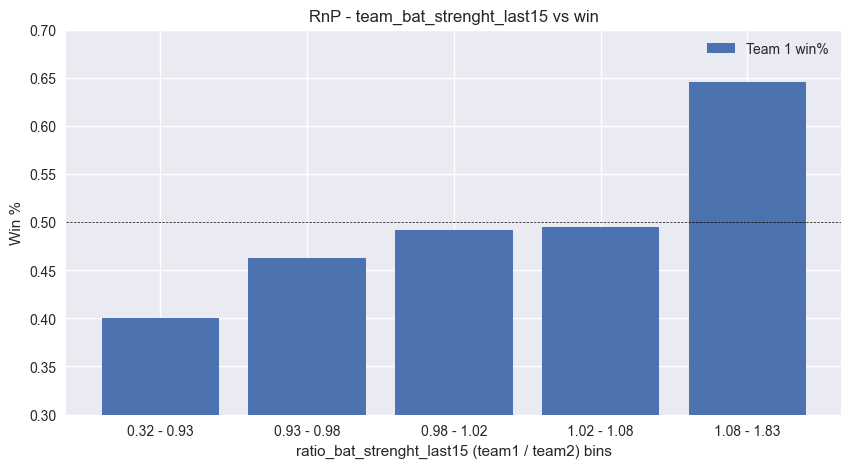

In [48]:
createRnP(train_data, 'team_bat_strenght_last15', N=5)

In [49]:
test_data['team1_bat_avg_last15'] = test_data.progress_apply(lambda x: \
                                  batavgLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_bat_avg_last15'] = test_data.progress_apply(lambda x: \
                                  batavgLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team1_bat_strike_rate_last15'] = test_data.progress_apply(lambda x: \
                                  batstrLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_bat_strike_rate_last15'] = test_data.progress_apply(lambda x: \
                                  batstrLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
test_data['team1_bat_strenght_last15'] = 0.40*test_data['team1_bat_avg_last15'] + 0.60*test_data['team1_bat_strike_rate_last15']
test_data['team2_bat_strenght_last15'] = 0.40*test_data['team2_bat_avg_last15'] + 0.60*test_data['team2_bat_strike_rate_last15']

test_data['team_bat_strenght_last15'] = test_data['team1_bat_strenght_last15']/ test_data['team2_bat_strenght_last15']

test_data.drop(columns=['team1_bat_avg_last15','team2_bat_avg_last15','team1_bat_strike_rate_last15','team2_bat_strike_rate_last15','team1_bat_strenght_last15','team2_bat_strenght_last15'], inplace=True) # dropping intermediate columns


 64%|██████▍   | 174/271 [00:02<00:01, 81.70it/s]/var/folders/y9/_3j91y_j5_sb6xs2vpf3h9840000gn/T/ipykernel_42870/1313283307.py:32: RuntimeWarning: invalid value encountered in scalar divide
  return total_runs/times_dismissed
 71%|███████   | 192/271 [00:02<00:00, 82.09it/s]/var/folders/y9/_3j91y_j5_sb6xs2vpf3h9840000gn/T/ipykernel_42870/1313283307.py:32: RuntimeWarning: invalid value encountered in scalar divide
  return total_runs/times_dismissed
 64%|██████▍   | 174/271 [00:02<00:01, 86.91it/s]/var/folders/y9/_3j91y_j5_sb6xs2vpf3h9840000gn/T/ipykernel_42870/46329268.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return (total_runs/total_balls_played) * 100.0
100%|██████████| 271/271 [00:03<00:00, 86.46it/s]


#### 8. Toss winner

In [50]:
# match_lvl_data['winner_01'] = match_lvl_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

In [51]:
train_data['toss_winner_01'] = train_data.apply(lambda x: 1 if (x['team1']==x['toss winner']) else 0, axis=1)

In [52]:
train_data.tail()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_runs_last15,team_consistency_last10,team1_winp_team2_last5,team1_bat_avg_last15,team2_bat_avg_last15,team1_bat_strike_rate_last15,team2_bat_strike_rate_last15,team1_bat_strenght_last15,team2_bat_strenght_last15,team_bat_strenght_last15,toss_winner_01
943,9128601,Pb Ks,30407,2789079.0:197658.0:2398346.0:2827327.0:2082044.0:5053082.0:2035102.0:3851518.0:7453697.0:7881845.0:3068547.0,Ci Sr Ks,30414,7422673.0:249087.0:3519011.0:5001170.0:232000.0:1642738.0:196580.0:2294823.0:360086.0:7879829.0:7968225.0,Pb Ks,30407,Ci Sr Ks,field,We Sm Mi,Mumbai,2022-04-25,night match,In Pr Le,2022,5004,0.823529,1.000000,147.333333,66.67,166.400000,0,0.936842,0.810127,66.67,18.227273,18.412587,133.370288,133.654822,87.313082,87.557928,0.997204,0
944,9433241,Mx,8700,4421689.0:7752989.0:1941743.0:4489722.0:7672874.0:4005406.0:7671166.0:4489708.0:8820538.0:2593758.0:3590362.0,St,9701,6139370.0:7694581.0:3294444.0:3239102.0:6320362.0:2535420.0:5288226.0:3252395.0:334963.0:2850868.0:55299.0,St,9701,St,field,Te Cr As Cy Gd Tn,Taunton,2023-06-02,day/night match,Vy Bt,2023,1042,1.571429,0.012346,167.400000,0.00,170.466667,1,1.125000,0.662791,0.00,18.152542,14.836601,124.607330,139.778325,82.025415,89.801636,0.913407,0
945,9097227,Bd,22497,4239773.0:1941743.0:3007969.0:4172972.0:1556253.0:3845029.0:2625895.0:3062555.0:4175772.0:6639156.0:4874092.0,Wn Pe,23869,323049.0:4876122.0:4164978.0:1837205.0:3373138.0:2204950.0:1858961.0:6640164.0:2659502.0:4159658.0:4239493.0,Wn Pe,23869,Bd,bat,St Gs Pk Pt Eh,Port Elizabeth,2022-02-07,day match,CA T0 Ce,2021/22,1224,3.000000,1.000000,NaN,0.00,NaN,1,1.210526,1.000000,0.00,20.826087,13.434783,128.074866,124.346076,85.175355,79.981559,1.064937,1
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.735537,1.363636,66.67,20.865385,20.860294,136.477987,141.850000,90.232946,93.454118,0.965532,1
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,3.034483,1.537190,100.00,17.335616,12.583333,137.554348,116.452442,89.466855,74.904799,1.194408,0


slope: 0.51 / 0.47 =  1.07


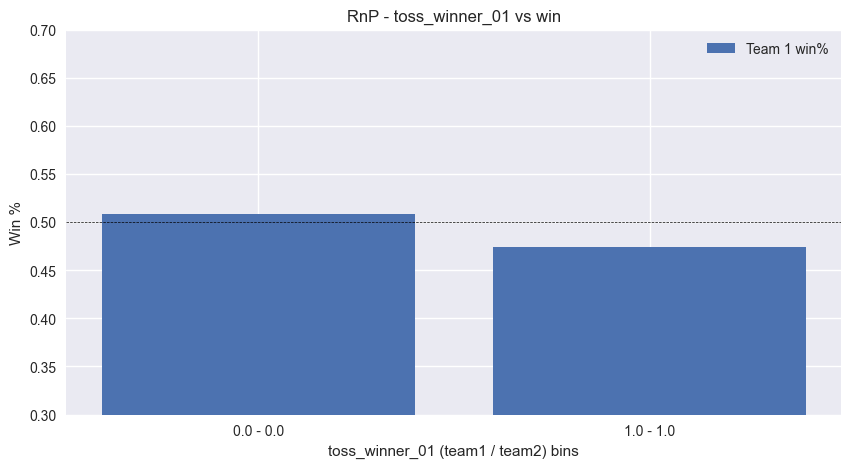

In [53]:
createRnP(train_data, 'toss_winner_01')

#### 9. Team1_bowling_average_last15 <br>

In [54]:
def bowlavgLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- bat avg of all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    total_runs = 0
    total_wickets = 0
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl') # getting batting stats from last n games for each player.

        total_runs += df_rel['runs'].sum()
        total_wickets += df_rel['wicket_count'].sum()
        # times_dismissed += df_rel['wicket kind'].apply(lambda x: x != '').sum()

        # if times_dismissed == 0:
        #     batting_average = np.nan #float('inf')  # If never dismissed, average is infinite
        # else:
        #     batting_average = total_runs / times_dismissed
        
        # res_list.append(batting_average)

    # return np.nanmean(res_list)
    return (total_runs+1)/(total_wickets+1)


In [55]:
train_data['team1_bowl_avg_last15'] = train_data.progress_apply(lambda x: \
                                  bowlavgLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_bowl_avg_last15'] = train_data.progress_apply(lambda x: \
                                  bowlavgLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


100%|██████████| 948/948 [00:09<00:00, 102.19it/s]


#### 10. Team_bowling_strike_rate_last15 <br>

In [56]:
def bowlstrLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- bat avg of all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    total_balls = 0
    total_wickets = 0
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl') # getting batting stats from last n games for each player.

        total_balls += df_rel['balls_bowled'].sum()
        total_wickets += df_rel['wicket_count'].sum()
        # times_dismissed += df_rel['wicket kind'].apply(lambda x: x != '').sum()

        # if times_dismissed == 0:
        #     batting_average = np.nan #float('inf')  # If never dismissed, average is infinite
        # else:
        #     batting_average = total_runs / times_dismissed
        
        # res_list.append(batting_average)

    # return np.nanmean(res_list)
    return (total_balls+1)/(total_wickets+1)


In [57]:
train_data['team1_bowl_strike_rate_last15'] = train_data.progress_apply(lambda x: \
                                  bowlstrLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_bowl_strike_rate_last15'] = train_data.progress_apply(lambda x: \
                                  bowlstrLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


100%|██████████| 948/948 [00:09<00:00, 99.83it/s] 


In [58]:
# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team1_bowl_strenght_last15'] = 0.3*train_data['team1_bowl_avg_last15'] + 0.7*train_data['team1_bowl_strike_rate_last15']
train_data['team2_bowl_strenght_last15'] = 0.3*train_data['team2_bowl_avg_last15'] + 0.7*train_data['team2_bowl_strike_rate_last15']

train_data['team_bowl_strenght_last15'] = train_data['team1_bowl_strenght_last15']/ train_data['team2_bowl_strenght_last15']

# train_data.drop(columns=['team1_bowl_avg_last15','team2_bowl_avg_last15','team1_bowl_strike_rate_last15','team2_bowl_strike_rate_last15','team1_bowl_strenght_last15','team2_bowl_strenght_last15'], inplace=True) # dropping intermediate columns


In [59]:
train_data.shape
train_data.tail(2)

(948, 42)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_runs_last15,team_consistency_last10,team1_winp_team2_last5,team1_bat_avg_last15,team2_bat_avg_last15,team1_bat_strike_rate_last15,team2_bat_strike_rate_last15,team1_bat_strenght_last15,team2_bat_strenght_last15,team_bat_strenght_last15,toss_winner_01,team1_bowl_avg_last15,team2_bowl_avg_last15,team1_bowl_strike_rate_last15,team2_bowl_strike_rate_last15,team1_bowl_strenght_last15,team2_bowl_strenght_last15,team_bowl_strenght_last15
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.735537,1.363636,66.67,20.865385,20.860294,136.477987,141.850000,90.232946,93.454118,0.965532,1,23.673913,25.752577,18.630435,19.082474,20.143478,21.083505,0.955414
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,3.034483,1.537190,100.00,17.335616,12.583333,137.554348,116.452442,89.466855,74.904799,1.194408,0,24.783133,27.789474,18.759036,19.473684,20.566265,21.968421,0.936174


slope: 0.49 / 0.49 =  1.02


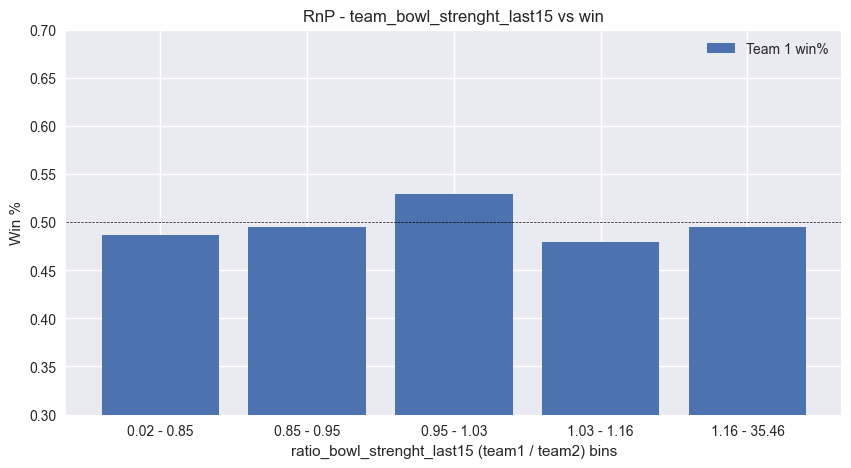

In [60]:
createRnP(train_data, 'team_bowl_strenght_last15')

In [61]:
test_data['team1_bowl_avg_last15'] = test_data.progress_apply(lambda x: \
                                  bowlavgLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_bowl_avg_last15'] = test_data.progress_apply(lambda x: \
                                  bowlavgLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team1_bowl_strike_rate_last15'] = test_data.progress_apply(lambda x: \
                                  bowlstrLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_bowl_strike_rate_last15'] = test_data.progress_apply(lambda x: \
                                  bowlstrLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
test_data['team1_bowl_strenght_last15'] = 0.3*test_data['team1_bowl_avg_last15'] + 0.7*test_data['team1_bowl_strike_rate_last15']
test_data['team2_bowl_strenght_last15'] = 0.3*test_data['team2_bowl_avg_last15'] + 0.7*test_data['team2_bowl_strike_rate_last15']

test_data['team_bowl_strenght_last15'] = test_data['team1_bowl_strenght_last15']/ test_data['team2_bowl_strenght_last15']

# test_data.drop(columns=['team1_bowl_avg_last15','team2_bowl_avg_last15','team1_bowl_strike_rate_last15','team2_bowl_strike_rate_last15','team1_bowl_strenght_last15','team2_bowl_strenght_last15'], inplace=True) # dropping intermediate columns


100%|██████████| 271/271 [00:02<00:00, 104.85it/s]


#### 10. wickets_taken_last15

In [62]:
def wickets_Lastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []

    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl') # getting batting stats from last n games for each player.
        df_rel['5_wicket_haul'] = np.where(df_rel['wicket_count']>=5, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        # df_rel['gte_100runs'] = np.where(df_rel['runs']>=100, 1, 0) 
        # df_rel['gte_30runs'] = np.where(df_rel['runs']>=30, 1, 0) 
        wicket_count = df_rel['wicket_count'].sum()
        final = 0.40* np.nansum(df_rel['5_wicket_haul']) + 0.60*wicket_count
        res_list.append(final)

    return np.nansum(res_list)


In [63]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['team1_count_wickets_last15'] = train_data.progress_apply(lambda x: \
            wickets_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Computing number of 50 wickets in last 15 games for team2 for train dataset.
train_data['team2_count_wickets_last15'] = train_data.progress_apply(lambda x: \
            wickets_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


100%|██████████| 948/948 [00:10<00:00, 91.63it/s]


In [64]:
# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_count_wickets_last15'] = (train_data['team1_count_wickets_last15']+1)/(train_data['team2_count_wickets_last15']+1)
train_data.drop(columns=['team1_count_wickets_last15','team2_count_wickets_last15'], inplace=True) # dropping intermediate columns

In [65]:
train_data.tail(2)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_runs_last15,team_consistency_last10,team1_winp_team2_last5,team1_bat_avg_last15,team2_bat_avg_last15,team1_bat_strike_rate_last15,team2_bat_strike_rate_last15,team1_bat_strenght_last15,team2_bat_strenght_last15,team_bat_strenght_last15,toss_winner_01,team1_bowl_avg_last15,team2_bowl_avg_last15,team1_bowl_strike_rate_last15,team2_bowl_strike_rate_last15,team1_bowl_strenght_last15,team2_bowl_strenght_last15,team_bowl_strenght_last15,team_count_wickets_last15
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.735537,1.363636,66.67,20.865385,20.860294,136.477987,141.850000,90.232946,93.454118,0.965532,1,23.673913,25.752577,18.630435,19.082474,20.143478,21.083505,0.955414,0.949153
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,3.034483,1.537190,100.00,17.335616,12.583333,137.554348,116.452442,89.466855,74.904799,1.194408,0,24.783133,27.789474,18.759036,19.473684,20.566265,21.968421,0.936174,1.450867


slope: 0.6 / 0.38 =  1.57


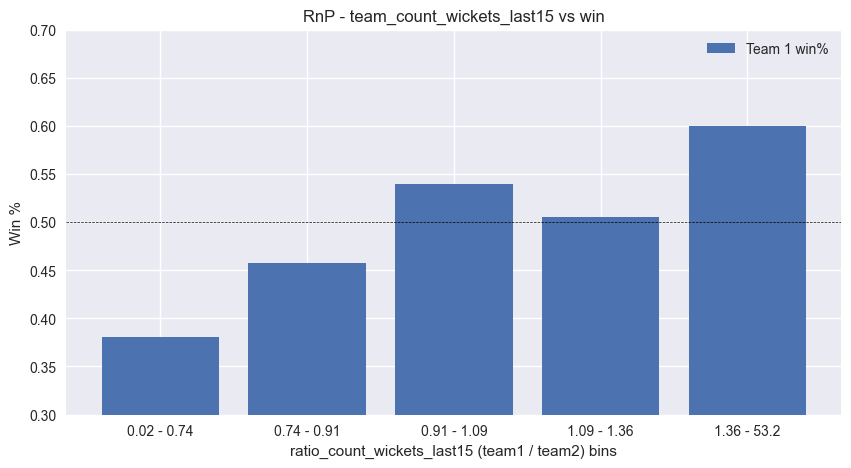

In [66]:
createRnP(train_data, 'team_count_wickets_last15')

In [67]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
test_data['team1_count_wickets_last15'] = test_data.progress_apply(lambda x: \
            wickets_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Computing number of 50 wickets in last 15 games for team2 for train dataset.
test_data['team2_count_wickets_last15'] = test_data.progress_apply(lambda x: \
            wickets_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
test_data['team_count_wickets_last15'] = (test_data['team1_count_wickets_last15']+1)/(test_data['team2_count_wickets_last15']+1)
test_data.drop(columns=['team1_count_wickets_last15','team2_count_wickets_last15'], inplace=True) # dropping intermediate columns


100%|██████████| 271/271 [00:02<00:00, 92.81it/s]


#### 11. Discipline factor

In [68]:
def discipline_Lastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []

    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl') # getting batting stats from last n games for each player.
        # df_rel['5_wicket_haul'] = np.where(df_rel['wicket_count']>=5, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        # df_rel['gte_100runs'] = np.where(df_rel['runs']>=100, 1, 0) 
        # df_rel['gte_30runs'] = np.where(df_rel['runs']>=30, 1, 0) 
        maiden = df_rel['maiden'].sum()
        extra = df_rel['noballs'].sum() + df_rel['wides'].sum()
        final = 0.60* extra + 0.40*maiden
        res_list.append(final)

    return np.nansum(res_list)


In [69]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['team1_discipline_last15'] = train_data.progress_apply(lambda x: \
            discipline_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Computing number of 50 wickets in last 15 games for team2 for train dataset.
train_data['team2_discipline_last15'] = train_data.progress_apply(lambda x: \
            discipline_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


100%|██████████| 948/948 [00:09<00:00, 100.77it/s]


In [70]:
# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_discipline_last15'] = (train_data['team1_discipline_last15']+1)/(train_data['team2_discipline_last15']+1)
train_data.drop(columns=['team1_discipline_last15','team2_discipline_last15'], inplace=True) # dropping intermediate columns

In [71]:
train_data.tail(2)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_runs_last15,team_consistency_last10,team1_winp_team2_last5,team1_bat_avg_last15,team2_bat_avg_last15,team1_bat_strike_rate_last15,team2_bat_strike_rate_last15,team1_bat_strenght_last15,team2_bat_strenght_last15,team_bat_strenght_last15,toss_winner_01,team1_bowl_avg_last15,team2_bowl_avg_last15,team1_bowl_strike_rate_last15,team2_bowl_strike_rate_last15,team1_bowl_strenght_last15,team2_bowl_strenght_last15,team_bowl_strenght_last15,team_count_wickets_last15,team_discipline_last15
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.735537,1.363636,66.67,20.865385,20.860294,136.477987,141.850000,90.232946,93.454118,0.965532,1,23.673913,25.752577,18.630435,19.082474,20.143478,21.083505,0.955414,0.949153,0.778261
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,3.034483,1.537190,100.00,17.335616,12.583333,137.554348,116.452442,89.466855,74.904799,1.194408,0,24.783133,27.789474,18.759036,19.473684,20.566265,21.968421,0.936174,1.450867,1.783133


slope: 0.54 / 0.43 =  1.26


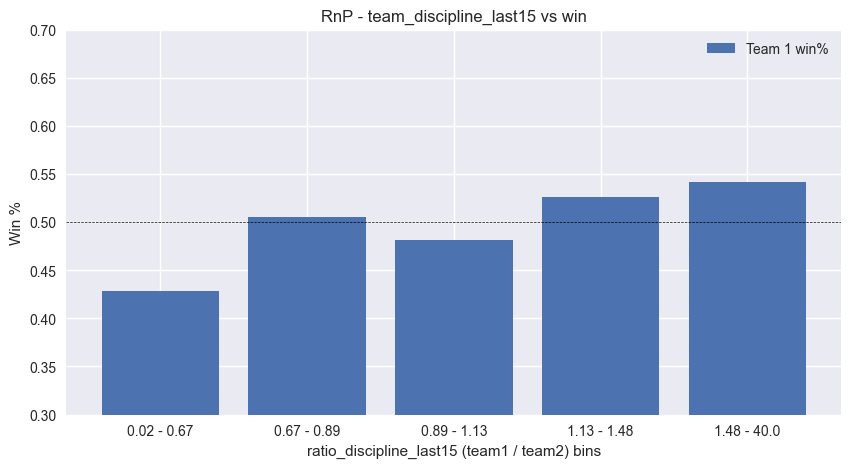

In [72]:
createRnP(train_data, 'team_discipline_last15')

In [73]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
test_data['team1_discipline_last15'] = test_data.progress_apply(lambda x: \
            wickets_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Computing number of 50 wickets in last 15 games for team2 for train dataset.
test_data['team2_discipline_last15'] = test_data.progress_apply(lambda x: \
            wickets_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
test_data['team_discipline_last15'] = (test_data['team1_discipline_last15']+1)/(test_data['team2_discipline_last15']+1)
test_data.drop(columns=['team1_discipline_last15','team2_discipline_last15'], inplace=True) # dropping intermediate columns


  0%|          | 0/271 [00:00<?, ?it/s]

100%|██████████| 271/271 [00:02<00:00, 93.13it/s]


#### 12. pressure index

In [74]:
match_lvl_data['series_type'].unique()

array(['other_domestic', 'international', 'In Pr Le'], dtype=object)

In [75]:
match_lvl_data['pressure_index'] = match_lvl_data.apply(lambda x: 0 if (x['series_type']=='other_domestic') else ( 1 if (x['series_type']=='In Pr Le') else 2), axis=1)

In [76]:
train_data = train_data.merge(match_lvl_data[['match id', 'pressure_index']], on='match id', how = 'left')

In [77]:
train_data.tail()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_runs_last15,team_consistency_last10,team1_winp_team2_last5,team1_bat_avg_last15,team2_bat_avg_last15,team1_bat_strike_rate_last15,team2_bat_strike_rate_last15,team1_bat_strenght_last15,team2_bat_strenght_last15,team_bat_strenght_last15,toss_winner_01,team1_bowl_avg_last15,team2_bowl_avg_last15,team1_bowl_strike_rate_last15,team2_bowl_strike_rate_last15,team1_bowl_strenght_last15,team2_bowl_strenght_last15,team_bowl_strenght_last15,team_count_wickets_last15,team_discipline_last15,pressure_index
943,9128601,Pb Ks,30407,2789079.0:197658.0:2398346.0:2827327.0:2082044.0:5053082.0:2035102.0:3851518.0:7453697.0:7881845.0:3068547.0,Ci Sr Ks,30414,7422673.0:249087.0:3519011.0:5001170.0:232000.0:1642738.0:196580.0:2294823.0:360086.0:7879829.0:7968225.0,Pb Ks,30407,Ci Sr Ks,field,We Sm Mi,Mumbai,2022-04-25,night match,In Pr Le,2022,5004,0.823529,1.000000,147.333333,66.67,166.400000,0,0.936842,0.810127,66.67,18.227273,18.412587,133.370288,133.654822,87.313082,87.557928,0.997204,0,25.089888,22.025000,19.426966,17.041667,21.125843,18.536667,1.139679,0.748619,0.783883,1
944,9433241,Mx,8700,4421689.0:7752989.0:1941743.0:4489722.0:7672874.0:4005406.0:7671166.0:4489708.0:8820538.0:2593758.0:3590362.0,St,9701,6139370.0:7694581.0:3294444.0:3239102.0:6320362.0:2535420.0:5288226.0:3252395.0:334963.0:2850868.0:55299.0,St,9701,St,field,Te Cr As Cy Gd Tn,Taunton,2023-06-02,day/night match,Vy Bt,2023,1042,1.571429,0.012346,167.400000,0.00,170.466667,1,1.125000,0.662791,0.00,18.152542,14.836601,124.607330,139.778325,82.025415,89.801636,0.913407,0,24.174603,19.301724,15.333333,14.758621,17.985714,16.121552,1.115632,0.539548,0.740741,0
945,9097227,Bd,22497,4239773.0:1941743.0:3007969.0:4172972.0:1556253.0:3845029.0:2625895.0:3062555.0:4175772.0:6639156.0:4874092.0,Wn Pe,23869,323049.0:4876122.0:4164978.0:1837205.0:3373138.0:2204950.0:1858961.0:6640164.0:2659502.0:4159658.0:4239493.0,Wn Pe,23869,Bd,bat,St Gs Pk Pt Eh,Port Elizabeth,2022-02-07,day match,CA T0 Ce,2021/22,1224,3.000000,1.000000,NaN,0.00,NaN,1,1.210526,1.000000,0.00,20.826087,13.434783,128.074866,124.346076,85.175355,79.981559,1.064937,1,23.058824,25.780488,18.058824,20.268293,19.558824,21.921951,0.892203,0.424000,0.535211,0
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.735537,1.363636,66.67,20.865385,20.860294,136.477987,141.850000,90.232946,93.454118,0.965532,1,23.673913,25.752577,18.630435,19.082474,20.143478,21.083505,0.955414,0.949153,0.778261,1
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,3.034483,1.537190,100.00,17.335616,12.583333,137.554348,116.452442,89.466855,74.904799,1.194408,0,24.783133,27.789474,18.759036,19.473684,20.566265,21.968421,0.936174,1.450867,1.783133,0


In [78]:
test_data = test_data.merge(match_lvl_data[['match id', 'pressure_index']], on='match id', how = 'left')

#### 13. Win % at venue

In [79]:
def winpVenueLastn(team_id, venue, date, n):
    '''
    Function to compute team1's win% against team2 from the current game in their past n encounters.
    
    Input-
    1. team1_id: ID of team1 to calculate win% of.
    2. team2_id: ID of team2 to calculate win% against.
    3: date: match date of the current game for which the feature is to be calculated.
    4. n: look-back window of games for both these teams.
    
    Output- None
    
    Returns- Float value denoting team1's win% against team2 in their past n games against each other.
    '''
    # filter out games where either team1_id is input team1 and team2_id is input team2, or where team2_id is input team1 and team1_id is input team2.
    # Also, match date is less than current games's input date, sort desc by date and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))&(match_lvl_data['ground_id']==venue)]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    
    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # Counting number of rows (games) where winner is input team1.
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return Float denoting team1's win% against team2 in past n games rounded to 2 decimal places.


In [80]:
# Compute team1 win% against team2 in their past 5 encounters for train data.
train_data['team1_winp_venue_last5'] = train_data.progress_apply(lambda x: \
                                  winpVenueLastn(x['team1_id'], x['ground_id'], x['match_dt'], 5), axis=1)
train_data['team2_winp_venue_last5'] = train_data.progress_apply(lambda x: \
                                  winpVenueLastn(x['team2_id'], x['ground_id'], x['match_dt'], 5), axis=1)


100%|██████████| 948/948 [00:00<00:00, 1760.82it/s]


In [81]:
train_data['team_winp_vanue_last5'] = (train_data['team1_winp_venue_last5']+1)/(train_data['team2_winp_venue_last5']+1)
train_data.drop(columns=['team1_winp_venue_last5', 'team2_winp_venue_last5'], inplace=True) # drop intermediate columns

In [82]:
train_data.tail(2)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_runs_last15,team_consistency_last10,team1_winp_team2_last5,team1_bat_avg_last15,team2_bat_avg_last15,team1_bat_strike_rate_last15,team2_bat_strike_rate_last15,team1_bat_strenght_last15,team2_bat_strenght_last15,team_bat_strenght_last15,toss_winner_01,team1_bowl_avg_last15,team2_bowl_avg_last15,team1_bowl_strike_rate_last15,team2_bowl_strike_rate_last15,team1_bowl_strenght_last15,team2_bowl_strenght_last15,team_bowl_strenght_last15,team_count_wickets_last15,team_discipline_last15,pressure_index,team_winp_vanue_last5
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.735537,1.363636,66.67,20.865385,20.860294,136.477987,141.850000,90.232946,93.454118,0.965532,1,23.673913,25.752577,18.630435,19.082474,20.143478,21.083505,0.955414,0.949153,0.778261,1,101.00000
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,3.034483,1.537190,100.00,17.335616,12.583333,137.554348,116.452442,89.466855,74.904799,1.194408,0,24.783133,27.789474,18.759036,19.473684,20.566265,21.968421,0.936174,1.450867,1.783133,0,0.02439


slope: 0.53 / 0.46 =  1.15


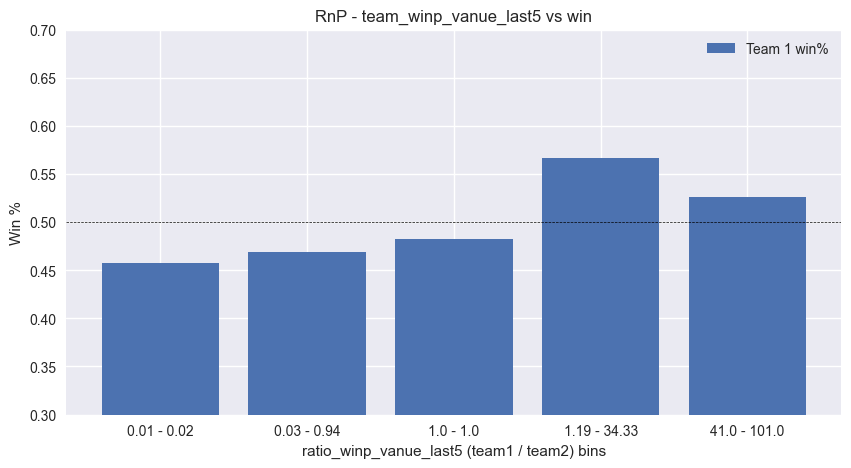

In [83]:
createRnP(train_data, 'team_winp_vanue_last5')

In [84]:
# Compute team1 win% against team2 in their past 5 encounters for train data.
test_data['team1_winp_venue_last5'] = test_data.progress_apply(lambda x: \
                                  winpVenueLastn(x['team1_id'], x['ground_id'], x['match_dt'], 5), axis=1)
test_data['team2_winp_venue_last5'] = test_data.progress_apply(lambda x: \
                                  winpVenueLastn(x['team2_id'], x['ground_id'], x['match_dt'], 5), axis=1)
test_data['team_winp_vanue_last5'] = (test_data['team1_winp_venue_last5']+1)/(test_data['team2_winp_venue_last5']+1)
test_data.drop(columns=['team1_winp_venue_last5', 'team2_winp_venue_last5'], inplace=True) # drop intermediate columns


100%|██████████| 271/271 [00:00<00:00, 1718.57it/s]


#### Final view

In [92]:
train_data.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'winner_01', 'team_count_runs_last15',
       'team_consistency_last10', 'team1_winp_team2_last5',
       'team1_bat_avg_last15', 'team2_bat_avg_last15',
       'team1_bat_strike_rate_last15', 'team2_bat_strike_rate_last15',
       'team1_bat_strenght_last15', 'team2_bat_strenght_last15',
       'team_bat_strenght_last15', 'toss_winner_01', 'team1_bowl_avg_last15',
       'team2_bowl_avg_last15', 'team1_bowl_strike_rate_last15',
       'team2_bowl_strike_rate_last15', 'team1_bowl_strenght_last15',
       'team2_bowl_strenght_last15', 'team_bowl_strenght_last15',
       'team_count_wickets_last1

In [93]:
train_data['winner_01'] = train_data.apply(lambda x: 1 if (x['team1']==x['winner']) else 0, axis=1)

In [94]:
train_data.tail(2)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_runs_last15,team_consistency_last10,team1_winp_team2_last5,team1_bat_avg_last15,team2_bat_avg_last15,team1_bat_strike_rate_last15,team2_bat_strike_rate_last15,team1_bat_strenght_last15,team2_bat_strenght_last15,team_bat_strenght_last15,toss_winner_01,team1_bowl_avg_last15,team2_bowl_avg_last15,team1_bowl_strike_rate_last15,team2_bowl_strike_rate_last15,team1_bowl_strenght_last15,team2_bowl_strenght_last15,team_bowl_strenght_last15,team_count_wickets_last15,team_discipline_last15,pressure_index,team_winp_vanue_last5
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,0,0.735537,1.363636,66.67,20.865385,20.860294,136.477987,141.850000,90.232946,93.454118,0.965532,1,23.673913,25.752577,18.630435,19.082474,20.143478,21.083505,0.955414,0.949153,0.778261,1,101.00000
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,0,3.034483,1.537190,100.00,17.335616,12.583333,137.554348,116.452442,89.466855,74.904799,1.194408,0,24.783133,27.789474,18.759036,19.473684,20.566265,21.968421,0.936174,1.450867,1.783133,0,0.02439


In [95]:
train_data.drop(columns=['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2', 'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'ground_avg_runs_last15', 'team1_winp_team2_last15', 'team1_bat_avg_last15', 'team2_bat_avg_last15',
       'team1_bat_strike_rate_last15', 'team2_bat_strike_rate_last15',
       'team1_bat_strenght_last15', 'team2_bat_strenght_last15', 'team1_bowl_avg_last15',
       'team2_bowl_avg_last15', 'team1_bowl_strike_rate_last15',
       'team2_bowl_strike_rate_last15', 'team1_bowl_strenght_last15',
       'team2_bowl_strenght_last15'], inplace=True) # drop intermediate columns


In [96]:
train_data.tail()

,winner_01,team_count_runs_last15,team_consistency_last10,team1_winp_team2_last5,team_bat_strenght_last15,toss_winner_01,team_bowl_strenght_last15,team_count_wickets_last15,team_discipline_last15,pressure_index,team_winp_vanue_last5
943,1,0.936842,0.810127,66.67,0.997204,0,1.139679,0.748619,0.783883,1,0.320988
944,0,1.125000,0.662791,0.00,0.913407,0,1.115632,0.539548,0.740741,0,0.016393
945,0,1.210526,1.000000,0.00,1.064937,1,0.892203,0.424000,0.535211,0,1.000000
946,0,0.735537,1.363636,66.67,0.965532,1,0.955414,0.949153,0.778261,1,101.000000
947,0,3.034483,1.537190,100.00,1.194408,0,0.936174,1.450867,1.783133,0,0.024390


In [97]:
test_data.tail()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_runs_last15,team_consistency_last10,team1_winp_team2_last5,team_bat_strenght_last15,team1_bowl_avg_last15,team2_bowl_avg_last15,team1_bowl_strike_rate_last15,team2_bowl_strike_rate_last15,team1_bowl_strenght_last15,team2_bowl_strenght_last15,team_bowl_strenght_last15,team_count_wickets_last15,team_discipline_last15,pressure_index,team_winp_vanue_last5
266,9094371,Ln St,46773,3200973.0:2958164.0:4223883.0:172199.0:4489974.0:1613926.0:5367676.0:1482998.0:5788418.0:2173688.0:4626236.0,Wh Fe,46752,8364726.0:4003390.0:2158869.0:3651472.0:2252452.0:2294823.0:4170186.0:5436878.0:3913475.0:2538983.0:2904943.0,Wh Fe,field,Ls Ln,London,2022-08-24,night match,Te Hd Ms Cn,2022,83,0.916667,2.904762,144.545455,0.00,145.181818,0.725275,1.039805,0.00,0.938948,23.958763,21.176471,18.082474,15.050420,19.845361,16.888235,1.175100,0.811634,0.811634,NaN,26.000000
267,9440500,Si La,69,7200598.0:4403531.0:2398346.0:5490582.0:3260564.0:3061225.0:5490666.0:4365878.0:7968225.0:3497171.0:5551062.0,Ia,55,5043310.0:7491224.0:3127354.0:3125562.0:4377610.0:3479860.0:3882850.0:7558949.0:8725709.0:3011735.0:7881845.0,Ia,field,Ma Ct An Sm Pe,Pune,2023-01-05,night match,Si La tr of Ia,2022/23,18752,0.714286,1.000000,159.066667,40.00,154.950000,0.692308,0.838710,40.00,0.898032,23.492308,23.084034,19.384615,16.865546,20.616923,18.731092,1.100679,0.554318,0.554318,NaN,1.000000
268,9085173,Sx,9967,2263736.0:164233.0:8820496.0:4215098.0:74087.0:4411231.0:6311612.0:5554254.0:3214812.0:8006676.0:1471994.0,Gn,7573,2531913.0:1722048.0:319948.0:5164844.0:4174610.0:6196280.0:8035894.0:3998070.0:2633196.0:3212278.0:7664957.0,Gn,field,Sa Gs Cf,Cardiff,2022-06-19,day match,Vy Bt,2022,4521,1.888889,2.904762,174.400000,50.00,146.821429,1.684211,1.184211,50.00,1.076105,26.162162,33.408163,17.945946,22.897959,20.410811,26.051020,0.783494,1.503356,1.503356,NaN,2.463415
269,8887752,Sy Tr,33963,7572123.0:1749075.0:6718802.0:5788320.0:7534652.0:1612610.0:7886864.0:5497274.0:3497633.0:8193310.0:8106713.0,Me Rs,33942,5406540.0:37351.0:46794.0:2336473.0:7534687.0:5469092.0:7537067.0:1905847.0:1906708.0:7620297.0:4985546.0,Me Rs,field,Ds Sm Me,Melbourne,2022-01-08,night match,Bg Bh Le,2021/22,8252,0.333333,1.487805,171.066667,100.00,161.750000,0.444444,1.044304,100.00,1.093774,28.448718,20.636364,18.948718,15.257576,21.798718,16.871212,1.292066,1.168317,1.168317,NaN,0.047619
270,9272472,Ht Hs,33928,2486896.0:2161599.0:5843200.0:6460614.0:6249256.0:50777.0:3459623.0:3507097.0:5788418.0:7629747.0:6732004.0,Me Rs,33942,2336473.0:5406540.0:8176356.0:37351.0:1635773.0:1934099.0:3715697.0:7537067.0:4393402.0:6818776.0:5459572.0,Ht Hs,bat,Be Ol Ht,Hobart,2022-12-24,day/night match,Bg Bh Le,2022/23,6348,0.454545,0.512195,178.533333,66.67,152.166667,0.683544,0.810127,66.67,1.073339,27.454545,19.723404,20.068182,15.414894,22.284091,16.707447,1.333782,0.936620,0.936620,NaN,41.000000


In [100]:
test_data.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'toss winner', 'toss decision', 'venue',
       'city', 'match_dt', 'lighting', 'series_name', 'season', 'ground_id',
       'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'team_count_runs_last15',
       'team_consistency_last10', 'team1_winp_team2_last5',
       'team_bat_strenght_last15', 'team1_bowl_avg_last15',
       'team2_bowl_avg_last15', 'team1_bowl_strike_rate_last15',
       'team2_bowl_strike_rate_last15', 'team1_bowl_strenght_last15',
       'team2_bowl_strenght_last15', 'team_bowl_strenght_last15',
       'team_count_wickets_last15', 'team_discipline_last15', 'pressure_index',
       'team_winp_vanue_last5'],
      dtype='object')

In [102]:
test_data['toss_winner_01'] = test_data.apply(lambda x: 1 if (x['team1']==x['toss winner']) else 0, axis=1)

In [103]:
test_data.tail()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_runs_last15,team_consistency_last10,team1_winp_team2_last5,team_bat_strenght_last15,team1_bowl_avg_last15,team2_bowl_avg_last15,team1_bowl_strike_rate_last15,team2_bowl_strike_rate_last15,team1_bowl_strenght_last15,team2_bowl_strenght_last15,team_bowl_strenght_last15,team_count_wickets_last15,team_discipline_last15,pressure_index,team_winp_vanue_last5,toss_winner_01
266,9094371,Ln St,46773,3200973.0:2958164.0:4223883.0:172199.0:4489974.0:1613926.0:5367676.0:1482998.0:5788418.0:2173688.0:4626236.0,Wh Fe,46752,8364726.0:4003390.0:2158869.0:3651472.0:2252452.0:2294823.0:4170186.0:5436878.0:3913475.0:2538983.0:2904943.0,Wh Fe,field,Ls Ln,London,2022-08-24,night match,Te Hd Ms Cn,2022,83,0.916667,2.904762,144.545455,0.00,145.181818,0.725275,1.039805,0.00,0.938948,23.958763,21.176471,18.082474,15.050420,19.845361,16.888235,1.175100,0.811634,0.811634,NaN,26.000000,0
267,9440500,Si La,69,7200598.0:4403531.0:2398346.0:5490582.0:3260564.0:3061225.0:5490666.0:4365878.0:7968225.0:3497171.0:5551062.0,Ia,55,5043310.0:7491224.0:3127354.0:3125562.0:4377610.0:3479860.0:3882850.0:7558949.0:8725709.0:3011735.0:7881845.0,Ia,field,Ma Ct An Sm Pe,Pune,2023-01-05,night match,Si La tr of Ia,2022/23,18752,0.714286,1.000000,159.066667,40.00,154.950000,0.692308,0.838710,40.00,0.898032,23.492308,23.084034,19.384615,16.865546,20.616923,18.731092,1.100679,0.554318,0.554318,NaN,1.000000,0
268,9085173,Sx,9967,2263736.0:164233.0:8820496.0:4215098.0:74087.0:4411231.0:6311612.0:5554254.0:3214812.0:8006676.0:1471994.0,Gn,7573,2531913.0:1722048.0:319948.0:5164844.0:4174610.0:6196280.0:8035894.0:3998070.0:2633196.0:3212278.0:7664957.0,Gn,field,Sa Gs Cf,Cardiff,2022-06-19,day match,Vy Bt,2022,4521,1.888889,2.904762,174.400000,50.00,146.821429,1.684211,1.184211,50.00,1.076105,26.162162,33.408163,17.945946,22.897959,20.410811,26.051020,0.783494,1.503356,1.503356,NaN,2.463415,0
269,8887752,Sy Tr,33963,7572123.0:1749075.0:6718802.0:5788320.0:7534652.0:1612610.0:7886864.0:5497274.0:3497633.0:8193310.0:8106713.0,Me Rs,33942,5406540.0:37351.0:46794.0:2336473.0:7534687.0:5469092.0:7537067.0:1905847.0:1906708.0:7620297.0:4985546.0,Me Rs,field,Ds Sm Me,Melbourne,2022-01-08,night match,Bg Bh Le,2021/22,8252,0.333333,1.487805,171.066667,100.00,161.750000,0.444444,1.044304,100.00,1.093774,28.448718,20.636364,18.948718,15.257576,21.798718,16.871212,1.292066,1.168317,1.168317,NaN,0.047619,0
270,9272472,Ht Hs,33928,2486896.0:2161599.0:5843200.0:6460614.0:6249256.0:50777.0:3459623.0:3507097.0:5788418.0:7629747.0:6732004.0,Me Rs,33942,2336473.0:5406540.0:8176356.0:37351.0:1635773.0:1934099.0:3715697.0:7537067.0:4393402.0:6818776.0:5459572.0,Ht Hs,bat,Be Ol Ht,Hobart,2022-12-24,day/night match,Bg Bh Le,2022/23,6348,0.454545,0.512195,178.533333,66.67,152.166667,0.683544,0.810127,66.67,1.073339,27.454545,19.723404,20.068182,15.414894,22.284091,16.707447,1.333782,0.936620,0.936620,NaN,41.000000,1


In [105]:
test_data['pressure_index'].isna()

0      True
1      True
2      True
3      True
4      True
       ... 
266    True
267    True
268    True
269    True
270    True
Name: pressure_index, Length: 271, dtype: bool

In [106]:
train_data.drop(columns=['pressure_index'], inplace = True)

In [108]:
test_data.drop(columns=['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2', 'team2_id', 'team2_roster_ids', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'ground_avg_runs_last15', 'team1_winp_team2_last15', 'team1_bowl_avg_last15',
       'team2_bowl_avg_last15', 'team1_bowl_strike_rate_last15',
       'team2_bowl_strike_rate_last15', 'team1_bowl_strenght_last15',
       'team2_bowl_strenght_last15', 'pressure_index'], inplace=True) # drop intermediate columns


In [109]:
test_data.tail()

,team_count_runs_last15,team_consistency_last10,team1_winp_team2_last5,team_bat_strenght_last15,team_bowl_strenght_last15,team_count_wickets_last15,team_discipline_last15,team_winp_vanue_last5,toss_winner_01
266,0.725275,1.039805,0.00,0.938948,1.175100,0.811634,0.811634,26.000000,0
267,0.692308,0.838710,40.00,0.898032,1.100679,0.554318,0.554318,1.000000,0
268,1.684211,1.184211,50.00,1.076105,0.783494,1.503356,1.503356,2.463415,0
269,0.444444,1.044304,100.00,1.093774,1.292066,1.168317,1.168317,0.047619,0
270,0.683544,0.810127,66.67,1.073339,1.333782,0.936620,0.936620,41.000000,1


In [110]:
train_data.tail()

,winner_01,team_count_runs_last15,team_consistency_last10,team1_winp_team2_last5,team_bat_strenght_last15,toss_winner_01,team_bowl_strenght_last15,team_count_wickets_last15,team_discipline_last15,team_winp_vanue_last5
943,1,0.936842,0.810127,66.67,0.997204,0,1.139679,0.748619,0.783883,0.320988
944,0,1.125000,0.662791,0.00,0.913407,0,1.115632,0.539548,0.740741,0.016393
945,0,1.210526,1.000000,0.00,1.064937,1,0.892203,0.424000,0.535211,1.000000
946,0,0.735537,1.363636,66.67,0.965532,1,0.955414,0.949153,0.778261,101.000000
947,0,3.034483,1.537190,100.00,1.194408,0,0.936174,1.450867,1.783133,0.024390


# Save

In [111]:
train_data.to_csv('train_data_processed.csv', index=False)
test_data.to_csv('test_data_processed.csv', index=False)